 # Lung_Cancer_Detection

### **About Dataset**

The Iraq-Oncology Teaching Hospital/National Center for Cancer Diseases (IQ-OTH/NCCD) lung cancer dataset was collected in the above-mentioned specialist hospitals over a period of three months in fall 2019. It includes CT scans of patients diagnosed with lung cancer in different stages, as well as healthy subjects. IQ-OTH/NCCD slides were marked by oncologists and radiologists in these two centers. The dataset contains a total of 1190 images representing CT scan slices of 110 cases (see Figure 1). These cases are grouped into three classes: normal, benign, and malignant. of these, 40 cases are diagnosed as malignant; 15 cases diagnosed with benign, and 55 cases classified as normal cases. The CT scans were originally collected in DICOM format. The scanner used is SOMATOM from Siemens. CT protocol includes: 120 kV, slice thickness of 1 mm, with window width ranging from 350 to 1200 HU a and window center from 50 to 600 were used for reading. with breath-hold at full inspiration. All images were de-identified before performing analysis. Written consent was waived by the oversight review board. The study was approved by the institutional review board of participating medical centers. Each scan contains several slices. The number of these slices range from 80 to 200 slices, each of them represents an image of the human chest with different sides and angles. The 110 cases vary in gender, age, educational attainment, area of residence, and living status. Some of them are employees of the Iraqi ministries of Transport and Oil, others are farmers and gainers. Most of them come from places in the middle region of Iraq, particularly, the provinces of Baghdad, Wasit, Diyala, Salahuddin, and Babylon.

### Import Packages

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import random
import os
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE

import tensorflow as tf
import keras
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array, array_to_img, plot_model
from keras.callbacks import EarlyStopping

import warnings
warnings.simplefilter("ignore", UserWarning)

In [2]:
base_directory = '/Users/hitam/Downloads/CNN/The IQ-OTHNCCD lung cancer dataset'
dataset_folder = 'The IQ-OTHNCCD lung cancer dataset'

In [3]:
categories = ['Bengin cases', 'Malignant cases', 'Normal cases']

In [4]:
size_data = {}
for i in categories:
    path = os.path.join(base_directory,dataset_folder ,i)
    class_num = categories.index(i)
    temp_dict = {}
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        height, width, channels = plt.imread(filepath).shape
        if str(height) + ' x ' + str(width) in temp_dict:
            temp_dict[str(height) + ' x ' + str(width)] += 1 
        else:
            temp_dict[str(height) + ' x ' + str(width)] = 1
    
    size_data[i] = temp_dict
        
size_data

{'Bengin cases': {'512 x 512': 120},
 'Malignant cases': {'512 x 623': 31,
  '512 x 512': 501,
  '512 x 801': 28,
  '404 x 511': 1},
 'Normal cases': {'512 x 512': 415, '331 x 506': 1}}

Bengin cases


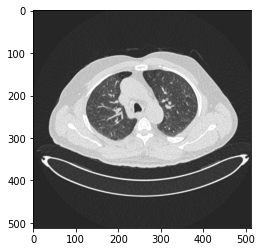

Malignant cases


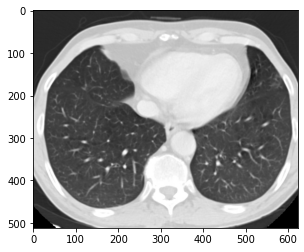

Normal cases


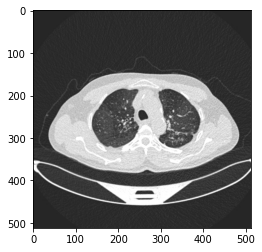

In [5]:
for i in categories:
    path = os.path.join(base_directory,dataset_folder ,i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        print(i)
        img = plt.imread(filepath, 0)
        plt.imshow(img)
        plt.show()
        break

In [6]:
import cv2
import imageio as imageio

Bengin cases


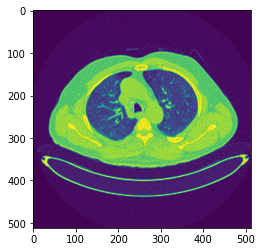

Malignant cases


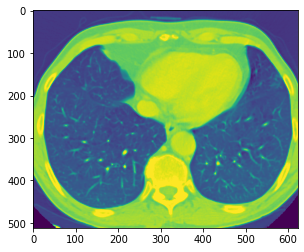

Normal cases


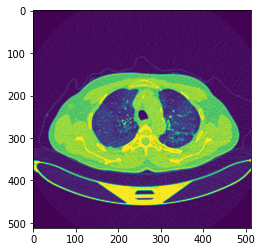

In [7]:
for i in categories:
    path = os.path.join(base_directory,dataset_folder ,i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        print(i)
        img = cv2.imread(filepath, 0)
        plt.imshow(img)
        plt.show()
        break

## Image Preprocessing 

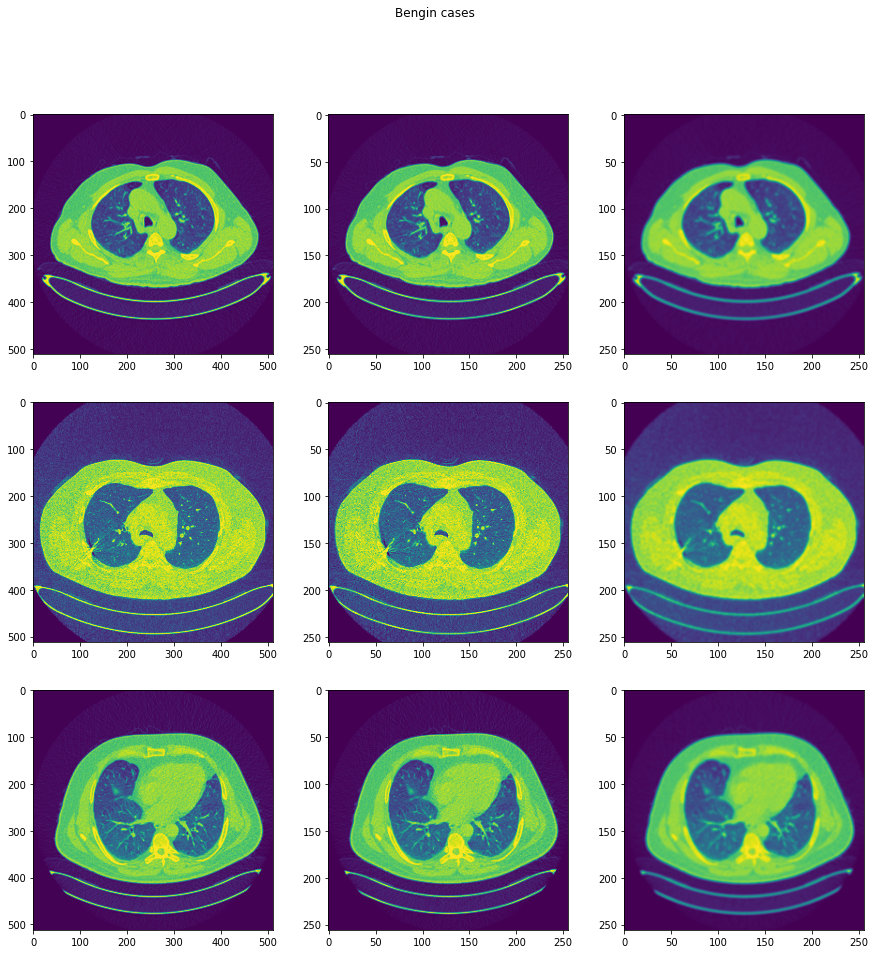

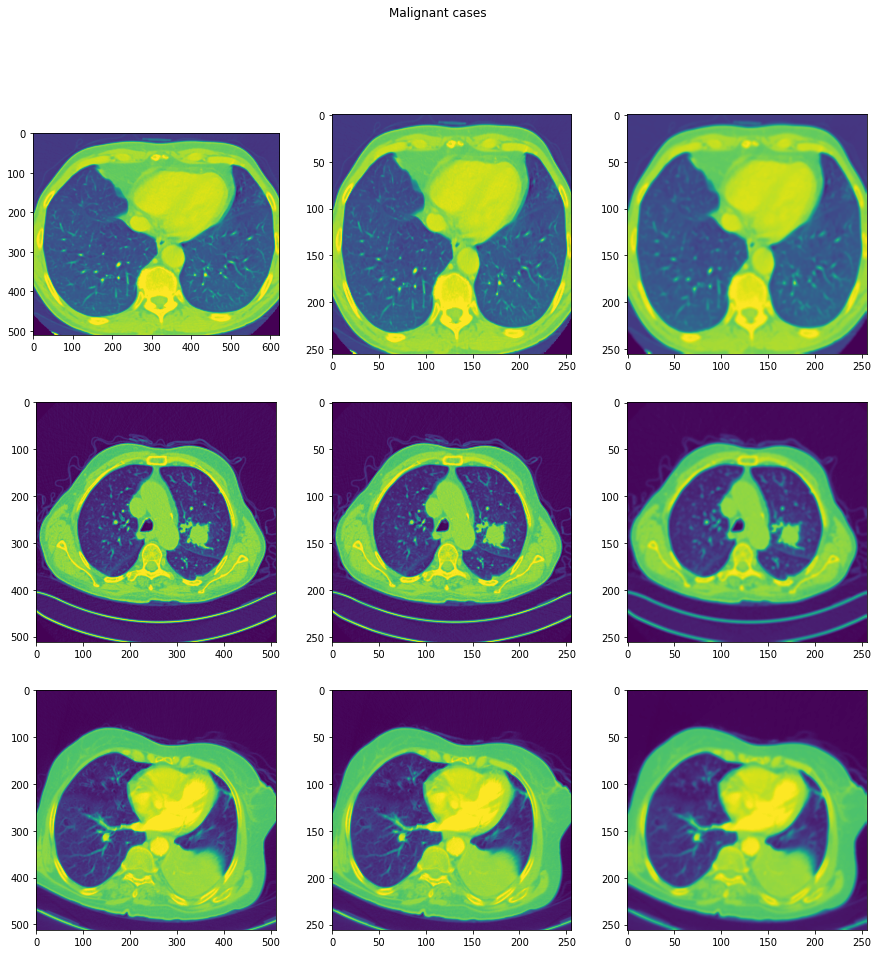

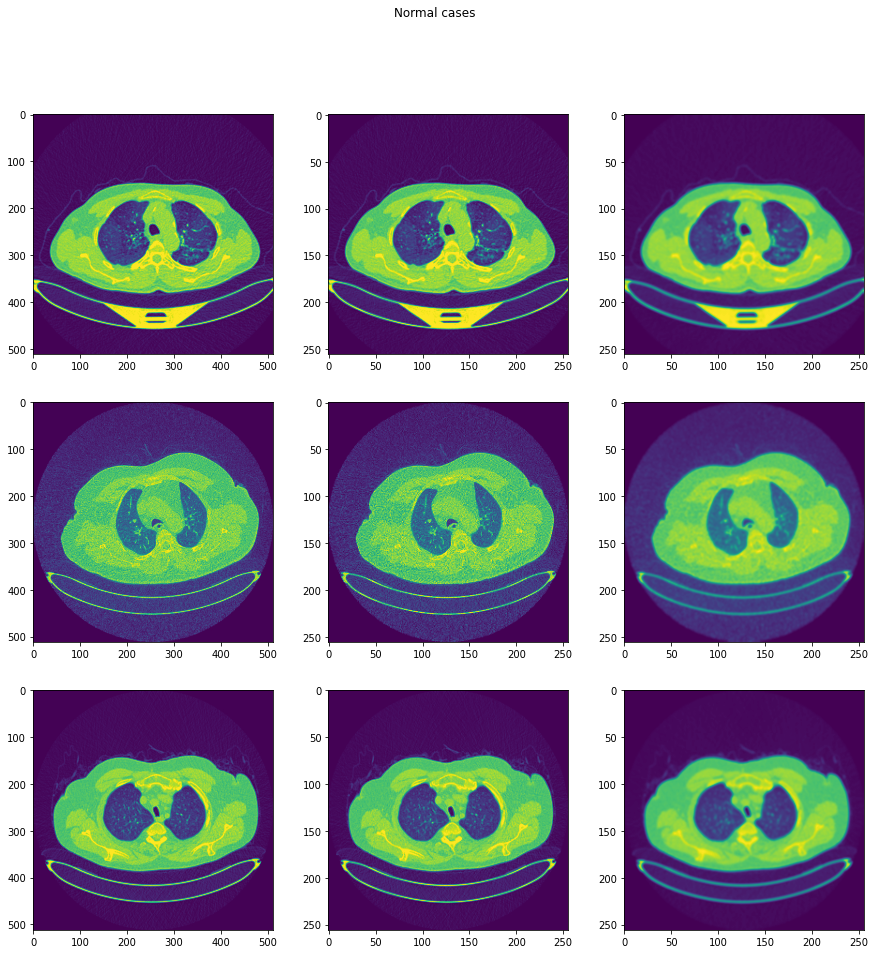

In [8]:
img_size = 256
for i in categories:    
    cnt, samples = 0, 3
    fig, ax = plt.subplots(samples, 3, figsize=(15, 15))
    fig.suptitle(i)
    
    path = os.path.join(base_directory,dataset_folder, i)
    class_num = categories.index(i)
    for curr_cnt, file in enumerate(os.listdir(path)):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        
        img0 = cv2.resize(img, (img_size, img_size))
        
        img1 = cv2.GaussianBlur(img0, (5, 5), 0)
        
        ax[cnt, 0].imshow(img)
        ax[cnt, 1].imshow(img0)
        ax[cnt, 2].imshow(img1)
        cnt += 1
        if cnt == samples:
            break
        
plt.show()

### Preparing Data

In [9]:
data = []
img_size = 256

for i in categories:
    path = os.path.join(base_directory,dataset_folder, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        # preprocess here
        img = cv2.resize(img, (img_size, img_size))
        data.append([img, class_num])
        
random.shuffle(data)

X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)
    
print('X length:', len(X))
print('y counts:', Counter(y))

X length: 1097
y counts: Counter({1: 561, 2: 416, 0: 120})


In [10]:
# normalize
X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0
y = np.array(y)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=10)

print('Train length:', len(X_train), X_train.shape)
print('Test length:', len(X_valid), X_valid.shape)

Train length: 767 (767, 256, 256, 1)
Test length: 330 (330, 256, 256, 1)


In [12]:
print(Counter(y_train), Counter(y_valid))

Counter({1: 393, 2: 291, 0: 83}) Counter({1: 168, 2: 125, 0: 37})


In [13]:
print(len(X_train), X_train.shape)

X_train = X_train.reshape(X_train.shape[0], img_size*img_size*1)

print(len(X_train), X_train.shape)

767 (767, 256, 256, 1)
767 (767, 65536)


### Applying SMOTE to oversample the data

In [14]:
print('Before SMOTE:', Counter(y_train))
smote = SMOTE()
X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)
print('After SMOTE:', Counter(y_train_sampled))

Before SMOTE: Counter({1: 393, 2: 291, 0: 83})
After SMOTE: Counter({1: 393, 2: 393, 0: 393})


In [15]:
X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
X_train_sampled = X_train_sampled.reshape(X_train_sampled.shape[0], img_size, img_size, 1)

print(len(X_train), X_train.shape)
print(len(X_train_sampled), X_train_sampled.shape)

767 (767, 256, 256, 1)
1179 (1179, 256, 256, 1)


### Model Building

In [16]:
model1 = Sequential()

model1.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dense(16))
model1.add(Dense(3, activation='softmax'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      640       
                                                                 
 activation (Activation)     (None, 254, 254, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 246016)            0

In [17]:
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
model1_history  = model1.fit(X_train_sampled, y_train_sampled, batch_size=8, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
148/148 [==============================] - 158s 1s/step - loss: 0.8254 - accuracy: 0.7880 - val_loss: 0.1911 - val_accuracy: 0.9394
Epoch 2/10
148/148 [==============================] - 149s 1s/step - loss: 0.0547 - accuracy: 0.9847 - val_loss: 0.0821 - val_accuracy: 0.9788
Epoch 3/10
148/148 [==============================] - 140s 948ms/step - loss: 0.0244 - accuracy: 0.9958 - val_loss: 0.0393 - val_accuracy: 0.9909
Epoch 4/10
148/148 [==============================] - 149s 1s/step - loss: 0.0452 - accuracy: 0.9924 - val_loss: 0.0778 - val_accuracy: 0.9848
Epoch 5/10
148/148 [==============================] - 192s 1s/step - loss: 0.0311 - accuracy: 0.9958 - val_loss: 0.0849 - val_accuracy: 0.9727
Epoch 6/10
148/148 [==============================] - 224s 2s/step - loss: 0.0375 - accuracy: 0.9941 - val_loss: 0.0398 - val_accuracy: 0.9848
Epoch 7/10
148/148 [==============================] - 174s 1s/step - loss: 0.0172 - accuracy: 0.9958 - val_loss: 0.0805 - val_accuracy: 0.9

In [19]:
y_pred = model1.predict(X_valid)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

11/11 [==============================] - 13s 1s/step
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        37
           1       0.99      1.00      0.99       168
           2       0.99      0.98      0.99       125

    accuracy                           0.99       330
   macro avg       0.99      0.99      0.99       330
weighted avg       0.99      0.99      0.99       330

[[ 36   0   1]
 [  0 168   0]
 [  0   2 123]]


In [20]:
score = accuracy_score(y_true=y_valid, y_pred=y_pred_bool)
score

0.990909090909091

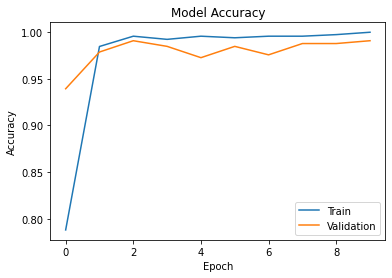

In [21]:
plt.plot(model1_history.history['accuracy'], label='Train')
plt.plot(model1_history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

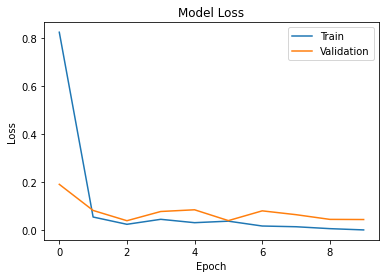

In [22]:
plt.plot(model1_history.history['loss'], label='Train')
plt.plot(model1_history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Model Building using ResNet

In [23]:
print(len(X_train), X_train.shape)

X_train = X_train.reshape(X_train.shape[0], img_size,img_size,1)

print(len(X_train), X_train.shape)

767 (767, 256, 256, 1)
767 (767, 256, 256, 1)


In [24]:
X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)


print(len(X_train), X_train.shape)


767 (767, 256, 256, 1)


In [25]:
from keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train, num_classes=3)
y_valid_one_hot = to_categorical(y_valid, num_classes=3)

In [26]:
# Data augmentation
train_datagen = ImageDataGenerator()

test_datagen = ImageDataGenerator()

In [27]:
train_generator = train_datagen.flow(X_train, y_train_one_hot, batch_size=8, shuffle=True)
validation_generator = test_datagen.flow(X_valid, y_valid_one_hot, batch_size=8, shuffle=True)

In [28]:
resnet = ResNet50(weights=None, include_top=False, input_shape=X_train.shape[1:])

# Freeze the layers
for layer in resnet.layers:
    layer.trainable = False

In [29]:
model = Sequential()

# Add the ResNet50 base model
model.add(resnet)


# Add custom classifier layers
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [30]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
# Callback for early stopping
callback = EarlyStopping(monitor='val_loss', patience=3)

In [32]:
# Model fitting
model_history = model.fit(train_generator, epochs=5, validation_data=validation_generator, callbacks=[callback])

Epoch 1/5
96/96 [==============================] - 317s 3s/step - loss: 0.9968 - accuracy: 0.5958 - val_loss: 0.8190 - val_accuracy: 0.6091
Epoch 2/5
96/96 [==============================] - 295s 3s/step - loss: 0.6675 - accuracy: 0.7223 - val_loss: 0.5790 - val_accuracy: 0.7697
Epoch 3/5
96/96 [==============================] - 289s 3s/step - loss: 0.5117 - accuracy: 0.8057 - val_loss: 0.7343 - val_accuracy: 0.7091
Epoch 4/5
96/96 [==============================] - 287s 3s/step - loss: 0.4581 - accuracy: 0.8175 - val_loss: 0.4716 - val_accuracy: 0.8212
Epoch 5/5
96/96 [==============================] - 290s 3s/step - loss: 0.4153 - accuracy: 0.8305 - val_loss: 0.4309 - val_accuracy: 0.8727


In [35]:
y_pred = model.predict(X_valid)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_valid, y_pred_bool))

11/11 [==============================] - 88s 8s/step
              precision    recall  f1-score   support

           0       0.59      0.81      0.68        37
           1       0.92      0.98      0.95       168
           2       0.93      0.74      0.83       125

    accuracy                           0.87       330
   macro avg       0.81      0.85      0.82       330
weighted avg       0.89      0.87      0.87       330

[[ 30   1   6]
 [  2 165   1]
 [ 19  13  93]]


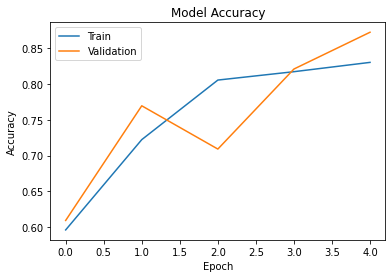

In [36]:
plt.plot(model_history.history['accuracy'], label='Train')
plt.plot(model_history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

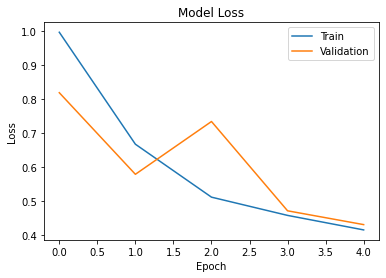

In [37]:
plt.plot(model_history.history['loss'], label='Train')
plt.plot(model_history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [38]:
score = accuracy_score(y_true=y_valid, y_pred=y_pred_bool)
score

0.8727272727272727